## imports

In [1]:
import math
import uuid
import time
import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf
import os
from utils.data_parser import features_description

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import itertools

## Create Dataset

In [2]:

ROOT = os.path.abspath(os.path.dirname(""))
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")
RESULTDIR = os.path.join(ROOT,"results")

FILE = "training_tfexample.tfrecord-00000-of-01000"
FILENAME = os.path.join(DATADIR,FILE)
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
data = next(dataset.as_numpy_iterator())
parsed = tf.io.parse_single_example(data, features_description)

## Helper functions for visualization

In [64]:
from cmath import pi


def create_figure_and_axes(size_pixels,axes_x=1,axes_y=1):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(axes_x,axes_y, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax

def get_viewport(all_states,all_states_mask):
  """
  Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width

  
def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

def get_colormap(num_steps):
  """Compute a color map array of shape [num_steps, 4]."""
  colors = cm.get_cmap('jet', num_steps)
  colors = colors(range(num_steps))
  np.random.shuffle(colors)
  return colors

def visualize_one_agent(states,
                        mask,
                        title,
                        center_y,
                        center_x,
                        color_map,
                        fig,
                        ax,
                        agent_type,
                        width,
                        linewidth=1,
                        traj=True,
                        ):
  """Generate visualization for all steps. num_agents = states[0,:]"""

  masked_x = states[:,0][mask]
  masked_y = states[:,1][mask]
  masked_angle = states[:,2][mask]
  masked_l = states[:,3][mask]
  masked_w = states[:,4][mask]


  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')


  if traj:
  # Plot one agent trajectory with marker 'o'
    ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=linewidth
    )
  else:
    # plot one agent trajectory with rectangualrs 
    for i,(x,y,angle,c) in enumerate(zip(masked_x,masked_y,masked_angle,color_map)):
      rect = plt.Rectangle((x,y),masked_l[i],masked_w[i],angle=angle/pi*180,color=c)
      ax.add_patch(rect)
  ax.set_title(title)
  # fig.colorbar(ax)


  image = fig_canvas_image(fig)
  return 0

## Generate visualization images

In [4]:
decoded_example = parsed
del parsed

# [num_agents, num_past_steps, 2] float32.
past_states = tf.stack(
    [decoded_example['state/past/x'], decoded_example['state/past/y'],decoded_example['state/past/bbox_yaw'],
    decoded_example['state/past/length'],decoded_example['state/past/width']],
    -1).numpy()
past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

# [num_agents, 1, 2] float32.
current_states = tf.stack(
    [decoded_example['state/current/x'], decoded_example['state/current/y'],decoded_example['state/current/bbox_yaw'],
    decoded_example['state/current/length'],decoded_example['state/current/width']],
    -1).numpy()
current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

# [num_agents, num_future_steps, 2] float32.
future_states = tf.stack(
    [decoded_example['state/future/x'], decoded_example['state/future/y'],decoded_example['state/future/bbox_yaw'],
    decoded_example['state/future/length'],decoded_example['state/future/width']],
    -1).numpy()
future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

# [num_points, 3] float32.
roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

num_agents, num_past_steps, _ = past_states.shape
num_future_steps = future_states.shape[1]

color_map = get_colormap(91)

# [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
all_states = np.concatenate([past_states, current_states, future_states], 1)

# [num_agens, num_past_steps + 1 + num_future_steps] float32.
all_states_mask = np.concatenate(
    [past_states_mask, current_states_mask, future_states_mask], 1)

center_y, center_x, width = get_viewport(all_states, all_states_mask)



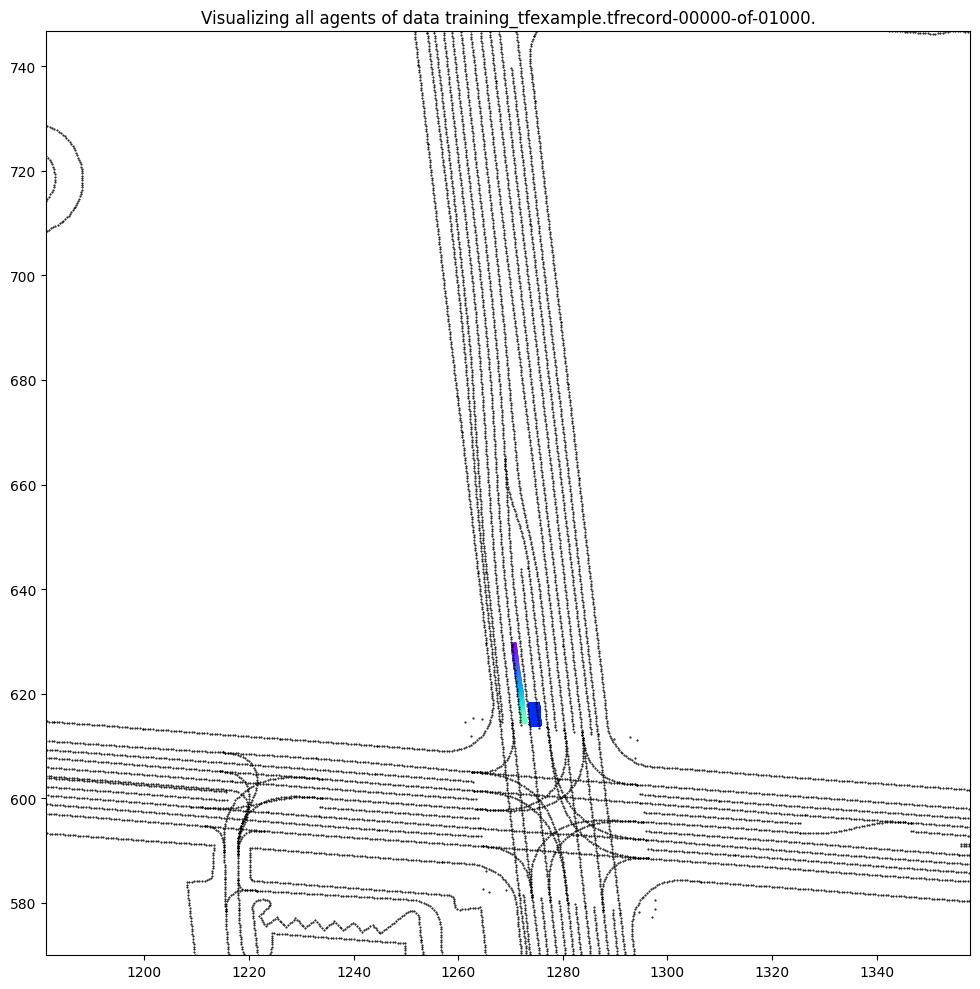

In [66]:
# Create figure and axes.
fig, ax = create_figure_and_axes(size_pixels=1000)

# Plot road graph
rg_pts = roadgraph_xyz[:,:2].T
ax.plot(rg_pts[0,:],rg_pts[1,:],'k.',alpha=1,ms=1)

from rich.progress import track

vehicle_ind = np.where(decoded_example['state/id']==1105.0)[0][0]
vru_ind = np.where(decoded_example['state/id']==4288.0)[0][0]

states = np.concatenate(([all_states[vehicle_ind,:,:]],[all_states[vru_ind,:,:]]))
states_mask = np.concatenate(([all_states_mask[vehicle_ind,:]],[all_states_mask[vru_ind,:]]))

# Generate image from all time steps
vs = np.linspace(0,100,91)
normal = plt.Normalize(0,91)
color_map = [plt.cm.Greys(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.ocean_r(normal(vs)),plt.cm.rainbow(normal(vs)),plt.cm.Purples(normal(vs))]

agent_type = [decoded_example['state/type'].numpy()[ind] for ind in [vehicle_ind,vru_ind]]

for i, (s,m) in enumerate (zip(states,states_mask)):
    title = f'Visualizing all agents of data {FILE}.'
    
    visualize_one_agent(s,m,title,center_y,center_x,color_map[int(agent_type[i])],fig,ax,int(agent_type[i]),width,traj=False)
    # print(i)



plt.show()

In [12]:
agent_type = [decoded_example['state/type'].numpy()[ind] for ind in [vehicle_ind,vru_ind]]

In [ ]:
vehicle_validity = decoded_example['state/past/valid'][vehicle_ind]
vehicle_validity


In [ ]:
VRU_validity = decoded_example['state/past/valid'][vru_ind]
VRU_validity

In [54]:
plt.cm.jet(normal(vs))

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.        , 0.55347594, 1.        ],
       [0.        , 0.        , 0.60695187, 1.        ],
       [0.        , 0.        , 0.66042781, 1.        ],
       [0.        , 0.        , 0.71390374, 1.        ],
       [0.        , 0.        , 0.76737968, 1.        ],
       [0.        , 0.        , 0.82085561, 1.        ],
       [0.        , 0.        , 0.87433155, 1.        ],
       [0.        , 0.        , 0.9456328 , 1.        ],
       [0.        , 0.        , 0.99910873, 1.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.03333333, 1.        , 1.        ],
       [0.        , 0.08039216, 1.        , 1.        ],
       [0.        , 0.12745098, 1.        , 1.        ],
       [0.        , 0.1745098 , 1.        , 1.        ],
       [0.        , 0.22156863, 1.        , 1.        ],
       [0.        , 0.28431373, 1.        , 1.        ],
       [0.        , 0.33137255,